In [1]:
# import dependencies
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from scipy.stats import linregress
from sodapy import Socrata
import gmaps
from config import g_keys

In [2]:
# used 'None', appication token with no password or username
client = Socrata("data.melbourne.vic.gov.au", None)
# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("b2ak-trbp", year=2019, limit=10000000)
# Convert to pandas DataFrame
results_2019_df = pd.DataFrame.from_records(results)
# len(results_df)
# save the dataframe
results_2019_df.to_csv('2019_foottraffick.csv')
results_2019_df.head()

## Data cleaning and wrangling

In [3]:
# check the data types 
results_2019_df.dtypes
# convert data types to fit requirements
data_type_dict = {"id":int,"year":int,"mdate":int,"time":int,"hourly_counts":float}
results_2019_df = results_2019_df.astype(data_type_dict)
results_2019_df.dtypes

id                 int64
date_time         object
year               int64
month             object
mdate              int64
day               object
time               int64
sensor_id         object
sensor_name       object
hourly_counts    float64
dtype: object

In [4]:
# create 
#results_2019_df= results_2019_df[(results_2019_df["time"] >= 12) & (results_2019_df["time"] <= 15)]
    
conditions=[
    (results_2019_df['time']>=7)&(results_2019_df['time']<=10),
    (results_2019_df['time']>=12)&(results_2019_df['time']<=14),
    (results_2019_df['time']>=17)&(results_2019_df['time']<=20)
]
period = ['morning peak','midday peak','evening peak']
# create a new column for peak times
results_2019_df['peak times']=np.select(conditions,period)
results_2019_df

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts,peak times
0,2887628,2019-11-01T17:00:00.000,2019,November,1,Friday,17,34,Flinders St-Spark La,300.0,evening peak
1,2887629,2019-11-01T17:00:00.000,2019,November,1,Friday,17,39,Alfred Place,604.0,evening peak
2,2887630,2019-11-01T17:00:00.000,2019,November,1,Friday,17,37,Lygon St (East),216.0,evening peak
3,2887631,2019-11-01T17:00:00.000,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627.0,evening peak
4,2887632,2019-11-01T17:00:00.000,2019,November,1,Friday,17,36,Queen St (West),774.0,evening peak
...,...,...,...,...,...,...,...,...,...,...,...
456824,2886659,2019-10-31T23:00:00.000,2019,October,31,Thursday,23,57,Bourke St Bridge,73.0,0
456825,2886660,2019-10-31T23:00:00.000,2019,October,31,Thursday,23,58,Bourke St - Spencer St (North),312.0,0
456826,2886661,2019-10-31T23:00:00.000,2019,October,31,Thursday,23,59,Swanston St - RMIT Building 80,3.0,0
456827,2886662,2019-10-31T23:00:00.000,2019,October,31,Thursday,23,61,Swanston St - RMIT Building 14,320.0,0


In [5]:
# group by unique id
sensor_data=results_2019_df.groupby('sensor_name').count()['peak times']
sensor_df=pd.DataFrame(sensor_data)
sensor_df=sensor_df.reset_index()
# sensor_df=sensor_df.rename(columns={'location': 'sensor_name'})
sensor_top_location=sensor_df.head(5)
sensor_top_location

,sensor_name,peak times
0,Alfred Place,8136
1,Birrarung Marr,6408
2,Bourke St - Spencer St (North),8760
3,Bourke St Bridge,8520
4,Bourke St-Russell St (West),8760


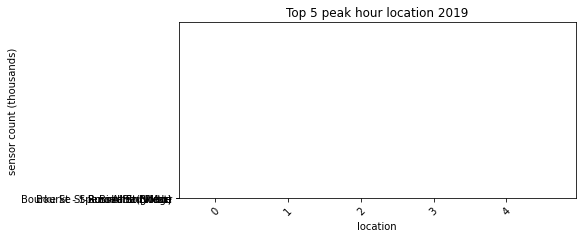

In [16]:
x_axis=np.arange(len(sensor_top_location))

tick_loc=[items for items in x_axis]

plt.figure(figsize=(8,3))
plt.bar(x_axis,sensor_top_location['sensor_name'], color='blue', alpha=0.8)
plt.xticks(tick_loc, rotation='45')
plt.tight_layout()

# Set x and y limits
plt.xlim(-.5, len(x_axis)-.05)
plt.ylim(0, 9000)

# Set a Title and labels
plt.title('Top 5 peak hour location 2019')
plt.xlabel('location')
plt.ylabel('sensor count (thousands)')

plt.show()

In [9]:
hourly_data=pd.DataFrame(results_2019_df.groupby('sensor_name').sum()['hourly_counts']).reset_index()
hourly_data

,sensor_name,hourly_counts
0,Alfred Place,2146897.0
1,Birrarung Marr,2136024.0
2,Bourke St - Spencer St (North),7083570.0
3,Bourke St Bridge,7236113.0
4,Bourke St-Russell St (West),5822623.0
...,...,...
56,Tin Alley-Swanston St (West),760854.0
57,Town Hall (West),12684222.0
58,Victoria Point,1642705.0
59,Waterfront City,597321.0


In [10]:
# get location coordinates

Location_list = hourly_data['sensor_name'].tolist()

sensor_name = []
latitude = []
longitude = []

for i in Location_list:
    try:
        base_url = "https://maps.googleapis.com/maps/api/geocode/json"
        target_location = i + ", Melbourne"
        params = {"address": target_location, "key": g_keys}
        response = requests.get(base_url, params=params)
        location_geo = response.json()
        lat = location_geo["results"][0]["geometry"]["location"]["lat"]
        lng = location_geo["results"][0]["geometry"]["location"]["lng"]
        print(f"{target_location}: {lat}, {lng}")
        sensor_name.append(i)
        latitude.append(lat)
        longitude.append(lng)
    except:
        print("Target location not found")

Alfred Place, Melbourne: -37.8143404, 144.9701942
Birrarung Marr, Melbourne: -37.8187351, 144.9742624
Bourke St - Spencer St (North), Melbourne: -37.8170606, 144.9533436
Bourke St Bridge, Melbourne: -37.8159602, 144.9572025
Bourke St-Russell St (West), Melbourne: -37.8159602, 144.9572025
Bourke Street Mall (North), Melbourne: -37.8137685, 144.9644379
Bourke Street Mall (South), Melbourne: -37.8137685, 144.9644379
Chinatown-Lt Bourke St (South), Melbourne: -37.8132372, 144.9627782
Chinatown-Swanston St (North), Melbourne: -37.8058235, 144.9631138
Collins Place (North), Melbourne: -37.8144674, 144.9733256
Collins Place (South), Melbourne: -37.8144674, 144.9733256
Collins St (North), Melbourne: -37.8182937, 144.956676
Elizabeth St-La Trobe St (East), Melbourne: -37.8102887, 144.9614233
Elizabeth St-Lonsdale St (South), Melbourne: -37.8122041, 144.962311
Faraday St-Lygon St (West), Melbourne: -37.7986322, 144.9673519
Flinders La - Swanston St (West) Temp, Melbourne: -37.8164851, 144.966988

In [11]:
# create new df for location coordinate

location_2019_dict = {
    "sensor_name": sensor_name,
    "Lat": latitude,
    "Lon": longitude,
    }
location_2019_df = pd.DataFrame(location_2019_dict)

location_2019_df.head()

,sensor_name,Lat,Lon
0,Alfred Place,-37.814340,144.970194
1,Birrarung Marr,-37.818735,144.974262
2,Bourke St - Spencer St (North),-37.817061,144.953344
3,Bourke St Bridge,-37.815960,144.957202
4,Bourke St-Russell St (West),-37.815960,144.957202


In [12]:
# merging foot traffic data and coord data
summary_2019 = location_2019_df.merge(hourly_data,how='left', on='sensor_name')
summary_2019.head()

,sensor_name,Lat,Lon,hourly_counts
0,Alfred Place,-37.814340,144.970194,2146897.0
1,Birrarung Marr,-37.818735,144.974262,2136024.0
2,Bourke St - Spencer St (North),-37.817061,144.953344,7083570.0
3,Bourke St Bridge,-37.815960,144.957202,7236113.0
4,Bourke St-Russell St (West),-37.815960,144.957202,5822623.0


In [13]:
# select longitude and latitude
coords=summary_2019[['Lat','Lon']]

# use peak times as weights
# convert it to float
weights=summary_2019['hourly_counts'].astype(float)
max_weights=weights.max()

# plot 2019 foot-traffic heat maps
fig = gmaps.figure()

heat_maps1=gmaps.heatmap_layer(coords, 
                               weights=weights, 
                               max_intensity=max_weights, 
                               point_radius=2, 
                               dissipating=False)

fig.add_layer(heat_maps1)

fig


Figure(layout=FigureLayout(height='420px'))